In [209]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')


def  cart2pol(x,y, units='deg'):
    """Convert from cartesian to polar coordinates

    :usage:

        theta, radius = pol2cart(x, y, units='deg')

    units refers to the units (rad or deg) for theta that should be returned
    """
    radius= np.hypot(x,y)
    theta= np.arctan2(y,x)
    if units in ['deg', 'degs']:
        theta=theta*180/np.pi
    return theta, radius


def pol2cart(theta, radius, units='deg'):
    """Convert from polar to cartesian coordinates

    usage::

        x,y = pol2cart(theta, radius, units='deg')

    """
    if units in ['deg', 'degs']:
        theta = theta*np.pi/180.0
    xx = radius*np.cos(theta)
    yy = radius*np.sin(theta)

    return xx,yy



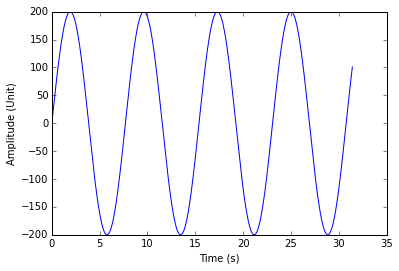

In [2]:
ncycles=5

t = np.linspace(0, 2*np.pi*ncycles, 20000, endpoint=True)
f = .13 #3.0 # Frequency in Hz
A = 200.0 # Amplitude in Unit
s = A * np.sin(2*np.pi*f*t) # Signal

plt.plot(t,s)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Unit)')

dt=0.00157s (Sample Time)
fa=636.59Hz (Frequency)


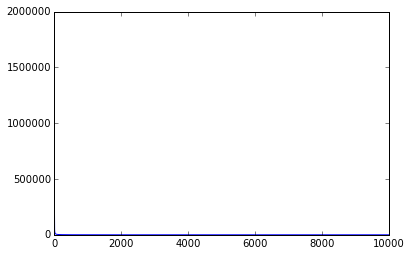

In [3]:
Y = np.fft.fft(s)
N = len(Y)/2+1

# plt.plot(np.abs(Y))
plt.plot(np.abs(Y[:N]))

dt = t[1] - t[0]
fa = 1.0/dt # scan frequency
print('dt=%.5fs (Sample Time)' % dt)
print('fa=%.2fHz (Frequency)' % fa)


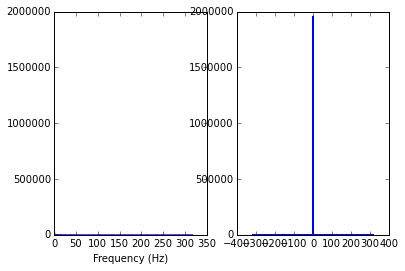

In [128]:
X1 = np.linspace(0, fa/2, N, endpoint=True)
X1[:4]

X2 = np.linspace(0, fa/2, len(Y), endpoint=True)

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.plot(X1, np.abs(Y[:N]))
plt.xlabel('Frequency (Hz)')

fig.add_subplot(1,2,2)
freqs = fft.fftfreq(len(Y), dt)
plt.plot(freqs, np.abs(Y))


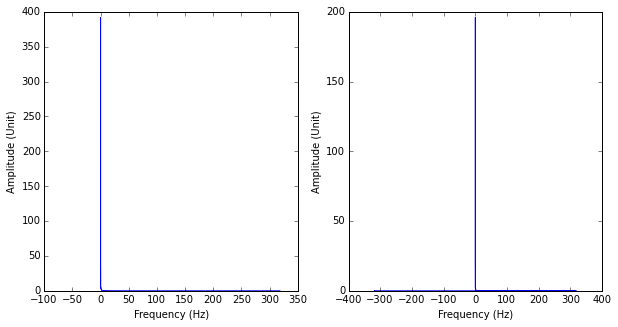

In [224]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
plt.plot(X, 2.0*np.abs(Y[:N])/N)
plt.xlim([-100, 350])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Unit)')

fig.add_subplot(1,2,2)
y=np.abs(Y)/N
plt.plot(freqs[0:N+1], y[0:N+1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (Unit)')


0.127317588276
195.875035972


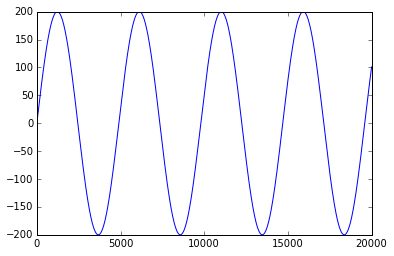

In [135]:
inv = np.fft.ifft(Y)
plt.plot(inv)
mag = np.abs(Y)

target = np.where(freqs == min(freqs, key=lambda x: abs(float(x) - f)))[0][0]
print freqs[target]
print mag[target]/N

In [241]:
# imdir = '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/V-Right_3'
# imdir = '/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/V-Right_0'

imdir = '/media/nas/volume1/widefield/data/JR009/20150625/20150625_JR009_500um_0050Hz/H-Down_0'

basepath = os.path.split(os.path.split(imdir)[0])[0]
session = os.path.split(os.path.split(imdir)[0])[1]
cond = os.path.split(imdir)[1]


In [242]:
target_freq = 0.05

circle = False
CW = False

get_average_cycle = False
im_format = '.png' #.tif'
reduce_factor = (2, 2)
reduceit = 1

sampling_rate = 60.  # np.mean(np.diff(sorted(strt_idxs)))/cycle_dur #60.0
cache_file = True
cycle_dur = 1. / target_freq  # 10.
binspread = 0

/media/nas/volume1/widefield/data/JR009/20150625/20150625_JR009_500um_0050Hz
['700-750um_ctxSurface_GREEN_Screen Shot 2015-06-25 at 4.02.45 PM.png']
['700-750um_ctxSurface_GREEN_Screen Shot 2015-06-25 at 4.02.45 PM.png']
.png


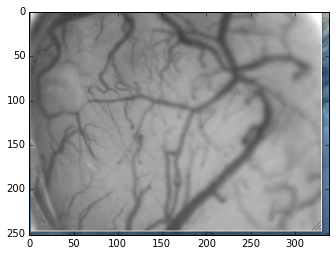

In [243]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################


rundir = os.path.split(imdir)[0]
sessiondir = os.path.split(rundir)[0]
reduceit=1
reduce_factor = (2,2)

folders = os.listdir(rundir)
figpath = [f for f in folders if f == 'figures']
print rundir

if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    print tmp_ims
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

# if reduceit:
#     surface = block_reduce(surface, reduce_factor, func=np.mean)

plt.imshow(surface, cmap='gray')

In [244]:

files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)

tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()

# FIND CYCLE STARTS:
if circle:
    positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
    plist = list(itertools.chain.from_iterable(positions))
    pos = []
    for i in plist:
        split_string = i.split(' ')
        split_num = [float(s) for s in split_string if s is not '']
        pos.append([split_num[0], split_num[1]])

    degs = [cart2pol(p[0], p[1], units='deg') for p in pos]

    degrees = [i[0] for i in degs]
    shift_degrees = [i[0] for i in degs]
    for x in range(len(shift_degrees)):
        if shift_degrees[x] < 0:
            shift_degrees[x] += 360.

    if CW:
        find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) > 0)))
    else:
        find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) < 0)))

else:
    # FIND CYCLE STARTS:
    positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
    plist = list(itertools.chain.from_iterable(positions))
    positions = [map(float, i.split(',')) for i in plist]
    if 'H-Up' in cond:
        find_cycs = list(itertools.chain.from_iterable(
            np.where(np.diff([p[1] for p in positions]) < 0)))
    if 'H-Down' in cond:
        find_cycs = list(itertools.chain.from_iterable(
            np.where(np.diff([p[1] for p in positions]) > 0)))
    if 'V-Left' in cond:
        find_cycs = list(itertools.chain.from_iterable(
            np.where(np.diff([p[0] for p in positions]) < 0)))
    if 'V-Right' in cond:
        find_cycs = list(itertools.chain.from_iterable(
            np.where(np.diff([p[0] for p in positions]) > 0)))

strt_idxs = [i + 1 for i in find_cycs]
strt_idxs.append(0)
strt_idxs.append(len(positions))
strt_idxs = sorted(strt_idxs)
nframes_per_cycle = [strt_idxs[i] - strt_idxs[i - 1] for i in range(1, len(strt_idxs))]

print nframes_per_cycle
print "sample shape: ", sample.shape

23973
23973
sample type: float64, range: [3658.0, 1649.0]
sample shape: (246, 328)
[1199, 1198, 1199, 1199, 1199, 1198, 1198, 1199, 1199, 1199, 1198, 1198, 1199, 1199, 1199, 1198, 1198, 1199, 1199, 1199]
sample shape:  (246, 328)


In [245]:
# READ IN THE FRAMES:
print reduce_factor

if reduceit:
    sample = block_reduce(sample, reduce_factor, func=np.mean)
    
print sample.shape

stack = np.empty((sample.shape[0], sample.shape[1], len(files)))
print len(files)

print('copying files')

for i, f in enumerate(files):

    if i % 100 == 0:
        print('%d images processed...' % i)
    tiff = TIFF.open(os.path.join(imdir, f), mode='r')
    im = tiff.read_image().astype('float')
    tiff.close()

    if reduceit:
        im_reduced = block_reduce(im, reduce_factor, func=np.mean)
        # ndimage.gaussian_filter(im_reduced, sigma=gsigma)
        stack[:, :, i] = im_reduced
    else:
        stack[:, :, i] = im

average_stack = np.mean(stack, axis=2)
import copy
S = copy.deepcopy(stack)

print "mean subtracting..."
for i in range(stack.shape[2]):
    stack[:,:,i] -= np.mean(stack[:,:,i].ravel()) 


print "detrending..."

for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant') # HP filter - over time...

        stack[x, y, :] = pix


(2, 2)
(123, 164)
23973
copying files
0 images processed...
100 images processed...
200 images processed...
300 images processed...
400 images processed...
500 images processed...
600 images processed...
700 images processed...
800 images processed...
900 images processed...
1000 images processed...
1100 images processed...
1200 images processed...
1300 images processed...
1400 images processed...
1500 images processed...
1600 images processed...
1700 images processed...
1800 images processed...
1900 images processed...
2000 images processed...
2100 images processed...
2200 images processed...
2300 images processed...
2400 images processed...
2500 images processed...
2600 images processed...
2700 images processed...
2800 images processed...
2900 images processed...
3000 images processed...
3100 images processed...
3200 images processed...
3300 images processed...
3400 images processed...
3500 images processed...
3600 images processed...
3700 images processed...
3800 images processed...

In [219]:
# TEST dB 

target_freq = 0.05
sampling_rate = 60.

freqs = fft.fftfreq(len(stack[0, 0, :]), 1 / sampling_rate)
target_bin = np.where(
    freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]

xlocs = [120, 120, 100]
ylocs = [200, 175, 150]
print sample.shape

# x = 120
# y = 200
ratio_map = np.empty(sample.shape)
dB_map = np.empty(sample.shape)
mags = np.empty(sample.shape)
norm_dB = np.empty(sample.shape)

for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):
        
        pix = fft.fft(stack[x,y,:])

        amp = np.abs(pix)

        targ_amp = amp[target_bin]*2.

        dB = 20*np.log(np.abs(pix)/len(pix))

        mag = np.abs(pix)/len(pix)

        normalized_amplitude = dB - max(dB)

        other_freqs = sum(amp) - targ_amp

        ratio_map[x, y] = targ_amp/other_freqs 
        dB_map[x, y] = dB[target_bin]
        mags[x, y] = mag[target_bin]
        norm_dB[x, y] = normalized_amplitude[target_bin]



(82, 110)


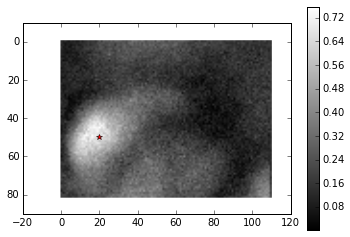

In [233]:
plt.imshow(np.abs(mags),cmap='gray')
plt.colorbar()

plt.plot(px, py, 'r*')

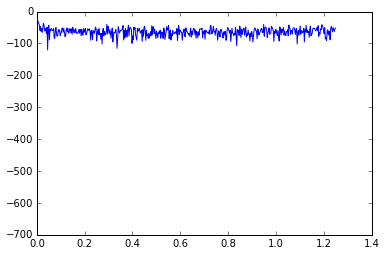

In [234]:
# plt.plot(D['freqs'], normalized_amplitude)
px = 18 #20 #50
py = 58 #70
pft = fft.fft(stack[px,py,:])
dB = 20*np.log(np.abs(pft)/len(pft))

norm_dB = dB - max(dB)

plt.plot(freqs[0:500], dB[0:500])

# plt.imshow(norm_dB, cmap='gray')
# plt.colorbar()

In [235]:
structdir = os.path.join(os.path.split(imdir)[0], 'structs')
print structdir
struct_pre = 'Target_fft_'
condition = os.path.split(imdir)[1]
reduce_factor = (2, 2)
reduce_size = str(reduce_factor)
append = '_nas' #_nas'

cond_structs = [i for i in os.listdir(structdir) if condition in i]
print cond_structs

curr_struct = struct_pre + condition + '_' + reduce_size + append + '.pkl'
struct_path = os.path.join(os.path.split(imdir)[0], 'structs', curr_struct)
# print os.listdir(os.path.split(structdir)[0])

D = pkl.load(open(struct_path, 'rb'))
print D.keys()

/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs
['D_fft_V-Right_3_(2, 2).hkl', 'D_target_V-Right_3_(2, 2)_.pkl', 'Target_fft_V-Right_3_(1, 1)_nas.pkl', 'V-Right_3_reduce1.jpg', 'Target_fft_V-Right_3_(1, 1)_nas_DC.pkl', 'Target_fft_V-Right_3_(1, 1)_detrendfirst.pkl', 'PHASE_map_Target_fft_V-Right_3_(1, 1)_nas_DC.pkl.jpg', 'MAG_map_Target_fft_V-Right_3_(1, 1)_nas_DC.pkl.jpg', 'Amplitudes_V-Right_3_(1, 1)_ratio.pkl', 'Amplitudes_V-Right_3_(1, 1)_detrend_last.pkl', 'Amplitudes_V-Right_3_(1, 1)_fft.pkl']


IOError: [Errno 2] No such file or directory: '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs/Target_fft_V-Right_3_(2, 2)_nas.pkl'

In [236]:
# A keys??

append = 'fft'
astructs = [f for f in cond_structs if 'Amplitudes' in f and append in f]
A = dict()
for f in astructs:
    print f
    outfile = os.path.join(structdir, f)
    with open(outfile,'rb') as fp:
        A[f] = pkl.load(fp)
print A.keys()

a_keys = A.keys() #[0]
print a_keys

Amplitudes_V-Right_3_(1, 1)_fft.pkl
['Amplitudes_V-Right_3_(1, 1)_fft.pkl']
['Amplitudes_V-Right_3_(1, 1)_fft.pkl']


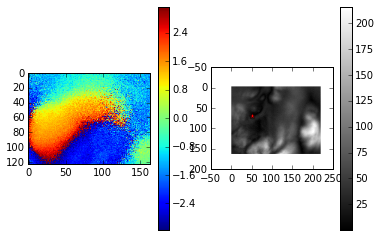

In [237]:


plt.subplot(1,2,1)
plt.imshow(D['phase_map'])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(A[a_keys[0]]['dB_map'], cmap='gray')
plt.colorbar()

x = 50
y = 70
plt.plot(x, y, 'r*')

In [238]:

print ratio_map[x,y]

pix = fft.fft(stack[x,y,:])

amp = np.abs(pix)

targ_amp = amp[target_bin]*2.

dB = 20*np.log(np.abs(pix)/len(pix))

mag = np.abs(pix)/len(pix)

normalized_amplitude = (dB - max(dB)) / (dB + max(dB))

other_freqs = sum(amp) - targ_amp
print "RATIO: ",  targ_amp/other_freqs 
print "targ dB: ", dB[target_bin]
print "norm dB: ", 2*dB[target_bin] / (sum(dB) - 2*dB[target_bin])

0.000333052615116
RATIO:  0.000333052615116
targ dB:  -33.3315014132
norm dB:  4.31281762313e-05


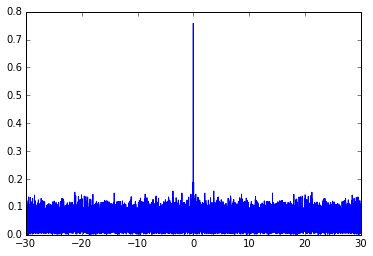

In [239]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

plt.plot(freqs, mag)
# data = {''}
# iplot(fig)

In [240]:
imdir = '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/V-Right_3'
struct_pre = 'Target_fft_'
condition = os.path.split(imdir)[1]
reduce_size = str(reduce_factor)

curr_struct = struct_pre + condition + '_' + reduce_size + '_nas.pkl'
structdir = os.path.join(os.path.split(imdir)[0], 'structs', curr_struct)
# print os.listdir(os.path.split(structdir)[0])

D = pkl.load(open(structdir, 'rb'))
print D.keys()


phase = D['phase_map']

Ny = len(D['freqs']) / 2 #+ 1
print "Nyquist: ", Ny

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
mag = D['mag_map']
normed_mag = mag/Ny
# frac_mag = mag / np.mean(average_stack.ravel())
print "Mean of means: ", np.mean(average_stack.ravel())

plt.imshow(normed_mag, cmap='gray')
plt.colorbar()
plt.title("Amplitude (range: %.3f, %.3f)" % (max(normed_mag.ravel()), min(normed_mag.ravel())))

# plt.subplot(1,2,2)
# plt.imshow(D['phase_map'])
# plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mag, cmap='gray')
plt.colorbar()
plt.title("Amplitude (range: %.3f, %.3f)" % (max(frac_mag.ravel()), min(frac_mag.ravel())))
# print ("At x=%i, y=%i, norm-mag = %.2f", % (x, y, normed_mag[x, y]))

IOError: [Errno 2] No such file or directory: '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs/Target_fft_V-Right_3_(2, 2)_nas.pkl'

In [198]:
fig = plt.figure(figsize=(20,15))
data = D['phase_map']

x = np.arange(data.shape[0])+0.5
y = np.arange(data.shape[1])+0.5
z = []
for i in range(data.shape[0]):
    z.append(data[i,:])

zflip = np.flipud(z)

from plotly.graph_objs import *

data = Data([
    Contour(
        z=zflip
    )
])
# plot_url = plot(data, filename='simple-contour')

py.iplot(data)

Amplitudes_H-Down_0_(2, 2)_fft.pkl
23973
/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/FIG_example_pixel_H-Down_0_x50_y70.jpg


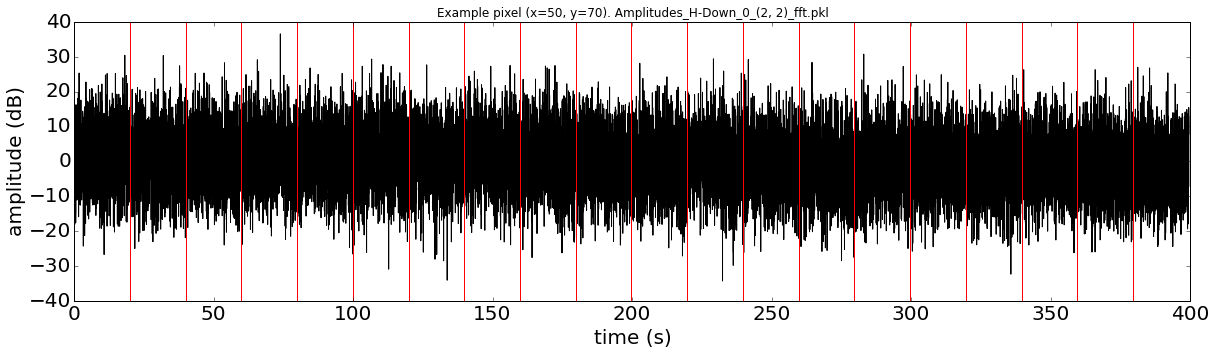

In [232]:
# plt.imshow(D['phase_map'])
# plt.colorbar()
print a_keys[0]


# fig = plt.figure(figsize=(20,5))
fig = plt.figure(figsize=(20,5), frameon=False)


# D = pkl.load(open(structdir, 'rb'))
# print D.keys()
# curr_phasemap = D['phase_map']
# curr_phasemap = D['phase_map']

plt.title(a_keys[0])
curr_phasemap = A[a_keys[0]]['dB_map']
# curr_phasemap = D['phase_map']

# fig.add_subplot(1,2,1)
ncycles=20
currx = 50 #80
curry = 70 #200
currpix = stack[currx, curry, :]

n_images = stack.shape[2]

t = np.arange(0, n_images/sampling_rate, 1.0/sampling_rate)
print (len(t))
# plt.plot(t, currpix[0:strt_idxs[ncycles]+1], 'k')
plt.plot(t, currpix, 'k')

plt.xlabel('time (s)', fontsize=20)
plt.ylabel('amplitude (dB)', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


for si in strt_idxs[0:ncycles]:
    plt.axvline(t[si],color='r')
    
# fig = plt.figure(frameon=False)
# ax = fig.add_axes([0, 0, 1, 1])
# ax.axis('off')

plt.title('Example pixel (x=%i, y=%i). %s' % (currx, curry, a_keys[0]))

# plt.xlabel('frame')
# plt.ylabel('amplitude')
# # plt.xlim([0, len(currpix)])
# # fig.add_subplot(1,2,2)
# # plt.imshow(curr_phasemap, cmap='spectral')
# # plt.axis('off')

outdir = os.path.split(imdir)[0]

imname = "FIG_example_pixel_%s_x%i_y%i" % (cond, currx, curry)
impath = os.path.join(outdir, imname+'.eps')
plt.savefig(impath, format='eps')

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath


/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/full_amplitude_example_V-Right_0_x50_y70.jpg


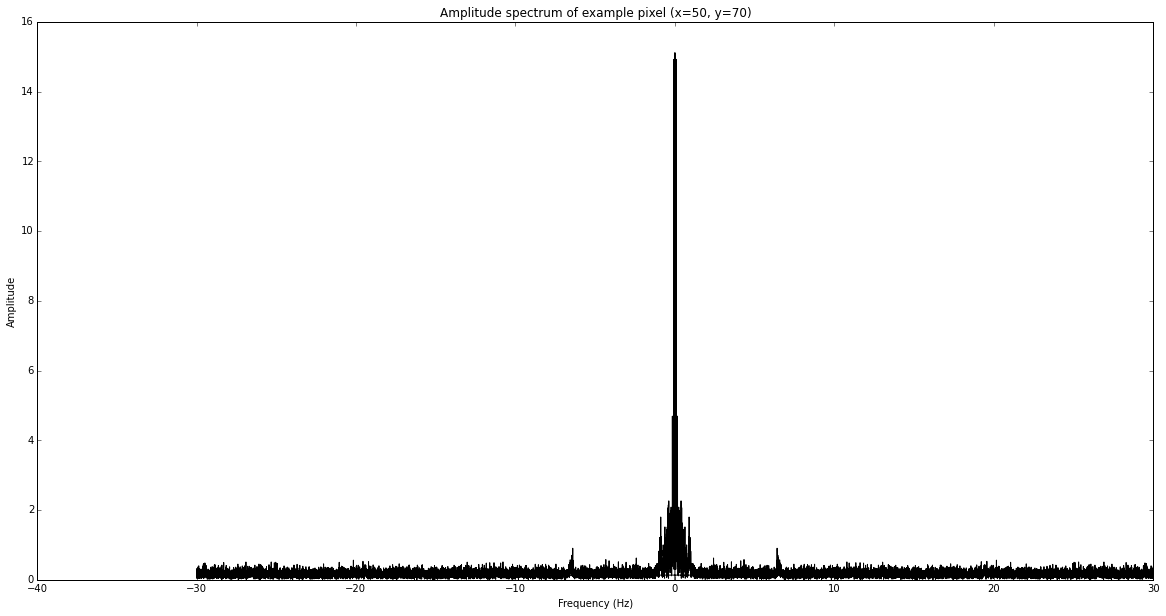

In [148]:
fig = plt.figure(figsize=(20,10))
currft = fft.fft(currpix)
Ny = len(D['freqs'])/2.
ploty=np.abs(currft)/Ny
plt.plot(D['freqs'], ploty, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Amplitude spectrum of example pixel (x=%i, y=%i)' % (currx, curry))

imname = "full_amplitude_example_%s_x%i_y%i" % (cond, currx, curry)
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath


/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/zoom_amplitude_example_V-Right_0_x50_y70.jpg


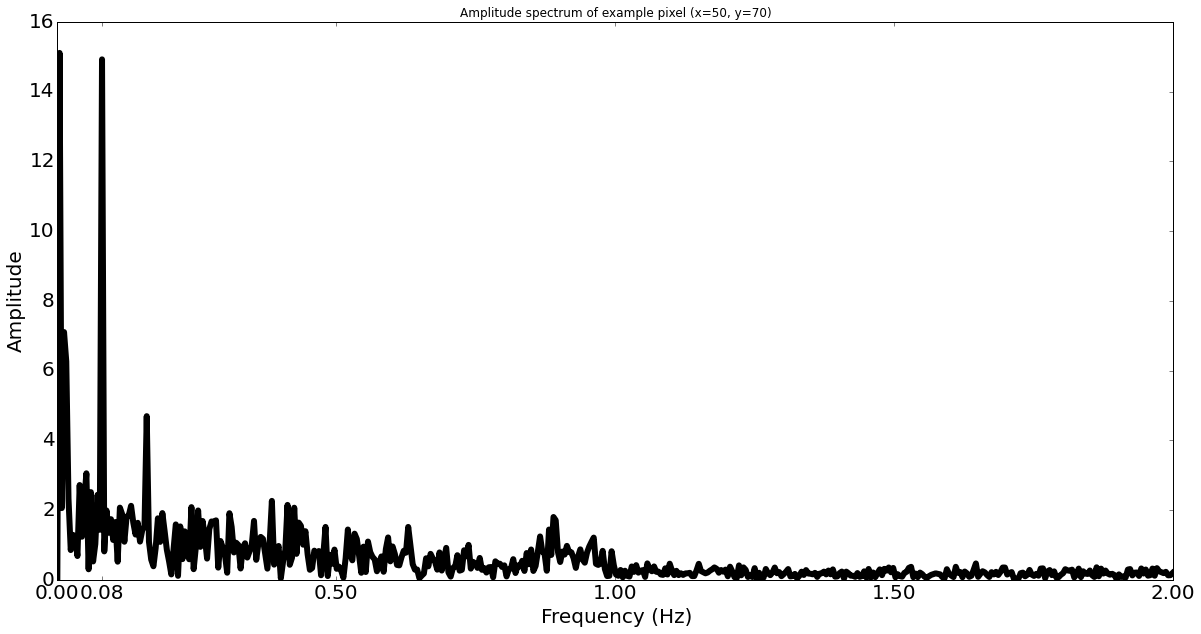

In [149]:
fig = plt.figure(figsize=(20,10))
currft = fft.fft(currpix)
Ny = len(D['freqs'])/2.
ploty=np.abs(currft)/Ny
plt.plot(D['freqs'][0:500], ploty[0:500], 'k', linewidth=6)

extraticks = [D['freqs'][D['target_bin']]]
# plt.xticklabel(D['freqs'][D['target_bin']])
#ax1 = plt.axes() 
#ax1.plot(D['freqs'][0:600], ploty[0:600])
# ax1.set_xticks([0.08])
plt.xticks(list(plt.xticks()[0]) + extraticks)

plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.title('Amplitude spectrum of example pixel (x=%i, y=%i)' % (currx, curry))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

imname = "zoom_amplitude_example_%s_x%i_y%i" % (cond, currx, curry)
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

In [167]:
print outdir
structdir = os.path.join(os.path.split(imdir)[0], 'structs')

files = os.listdir(structdir)

files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
# print files

# MEAN-SUBTRACTED ANALYSIS:
# append = 'detrendfirst' #nas' #'detrendlast'
dstructs = [f for f in files if 'Target_fft_' in f]
# dstructs = [d for d in dstructs if append in d]
# print dstructs
D = dict()
for f in dstructs:
    outfile = os.path.join(structdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)
print D.keys()

append='fft'
astructs = [f for f in files if 'Amplitudes' in f and append in f]
A = dict()
for f in astructs:
	outfile = os.path.join(outdir,'structs', f)
	with open(outfile,'rb') as fp:
		A[f] = pkl.load(fp)
# print A.keys()

a_keys = A.keys() #[0]
print a_keys

/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED
['Target_fft_H-Down_0_(2, 2)_.pkl', 'Target_fft_V-Left_0_(2, 2)_nomean.pkl', 'Target_fft_V-Right_0_(2, 2)_.pkl', 'Target_fft_H-Up_0_(2, 2)_.pkl', 'Target_fft_V-Right_0_(2, 2)_detrendfirst.pkl', 'Target_fft_H-Down_0_(2, 2)_detrendfirst.pkl', 'Target_fft_V-Left_0_(2, 2)_ratio.pkl', 'Target_fft_V-Left_0_(2, 2)_filter.pkl', 'Target_fft_H-Down_0_(2, 2)_filter.pkl', 'Target_fft_V-Left_0_(2, 2)_subtractmean.pkl', 'Target_fft_V-Left_0_(2, 2)_detrendfirst.pkl', 'Target_fft_V-Right_0_(2, 2)_filter.pkl', 'Target_fft_V-Left_0_(2, 2)_detrendlast.pkl', 'Target_fft_V-Left_0_(2, 2)_.pkl', 'Target_fft_V-Right_0_(2, 2)_detrendlast.pkl', 'Target_fft_H-Up_0_(2, 2)_filter.pkl']
['Amplitudes_H-Down_0_(2, 2)_fft.pkl', 'Amplitudes_V-Right_0_(2, 2)_fft.pkl', 'Amplitudes_H-Up_0_(2, 2)_fft.pkl', 'Amplitudes_V-Left_0_(2, 2)_fft.pkl']


In [173]:
curr_key = ''
a_key = ''

cond = 'Right'
append='fft'
a_key = [a for a in a_keys if cond in a and append in a][0]
print a_key


run_num = 0 #3 #3
reduce_factor = (2, 2) #(1, 1) #(2, 2)
append = 'detrendlast'  #'nas_DC' #detrendfirst' #filter' #'nas'
cond_type = cond

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in dstructs if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print dstructs
else:
    curr_key = tmp_keys[0]
#     print "Curr key is: ", leftkey

# curr_key = [d for d in D.keys() if cond in d][0]
print "a_key: ", a_key
print "curr_key: ", curr_key

Amplitudes_V-Right_0_(2, 2)_fft.pkl
a_key:  Amplitudes_V-Right_0_(2, 2)_fft.pkl
curr_key:  Target_fft_V-Right_0_(2, 2)_detrendlast.pkl


Hue range:  2.98424369971e-05 0.999888322623
Val range:  0.00012257718208 0.0142557410615
0.857442589385 1.0
/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/PHASE_example_pixel_Amplitudes_V-Right_0_(2, 2)_fft.pkl_x50_y70.jpg


<matplotlib.colorbar.Colorbar instance at 0x7f4853e1bf38>

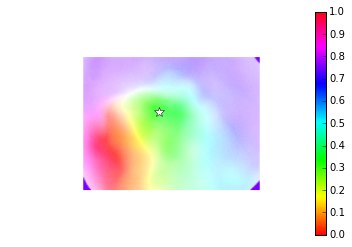

In [200]:
ratio_map = A[a_key]['ratio_map']
phase_map = np.angle(D[curr_key]['ft'])

# NORMALIZE to HSV:
import math

Ny = len(D[curr_key]['freqs'])/2.

old_min = -math.pi #phase_map.min()
old_max = math.pi #phase_map.max()
new_min = 0
new_max = 1
normed_phase_map = np.zeros(phase_map.shape)
for x in range(phase_map.shape[0]):
    for y in range(phase_map.shape[1]):
        old_val = phase_map[x, y]
        normed_phase_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

hue = normed_phase_map
sat = np.ones(hue.shape)
val = ratio_map #/Ny #normed_mag_map

HSV = np.ones(val.shape + (3,))
HSV[...,0] = hue
HSV[...,2] = sat * 1
HSV[...,1] = val * 10

print "Hue range: ", hue.min(), hue.max()
print "Val range: ", val.min(), val.max()

import colorsys
hsv_to_rgb = np.empty(HSV.shape)

for i in range(HSV.shape[0]):
    for j in range(HSV.shape[1]):

            hsv_to_rgb[i, j, :] = colorsys.hsv_to_rgb(HSV[i,j,:][0],HSV[i,j,:][1],HSV[i,j,:][2])

            
# MASK:
print hsv_to_rgb.min(), hsv_to_rgb.max()

old_min = hsv_to_rgb.min()
old_max = hsv_to_rgb.max()
new_min = 0
new_max = 1
renorm_rgb = np.zeros(hsv_to_rgb.shape)
for x in range(hsv_to_rgb.shape[0]):
    for y in range(hsv_to_rgb.shape[1]):
        old_val = hsv_to_rgb[x, y]
        renorm_rgb[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min



# plt.imshow(surface, 'gray')
plt.imshow(renorm_rgb, 'hsv') #, vmin=0, vmax=1)
# plt.axis('off')
# plt.colorbar()

plt.plot(curry, currx, 'w*', markersize=10)

plt.axis('off')


imname = "PHASE_example_pixel_%s_x%i_y%i" % (a_key, currx, curry)
# impath = os.path.join(os.path.split(imdir)[0], imname+'.svg')
# plt.savefig(impath, format='svg', dpi=1200)

# impath = os.path.join(os.path.split(imdir)[0], imname+'.jpg')
# plt.savefig(impath, format='jpg')

print impath
plt.colorbar()

/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/V_right_normalized_legend.jpg


<matplotlib.colorbar.Colorbar instance at 0x7f48547073f8>

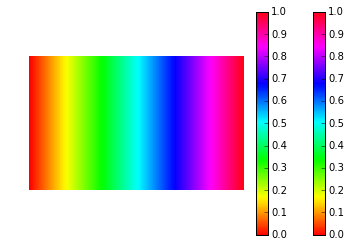

In [208]:
screen_size = [400, 250]

H_down_legend = np.zeros((screen_size[1], screen_size[0]))
# First, set half the screen width (0 to 239 = to 0 to -pi)
nspaces_start = np.linspace(1, 0, screen_size[1])
for i in range(screen_size[0]):
    H_down_legend[0:screen_size[1], i] = nspaces_start

# Then, set right side of screen (240 to end = to pi to 0)
nspaces_end = np.linspace(1*math.pi, 0, screen_size[1]/2)
for i in range(screen_size[0]):
    H_down_legend[screen_size[1]/2:, i] = nspaces_end


/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/brain.jpg


(-0.5, 338.5, 251.5, -0.5)

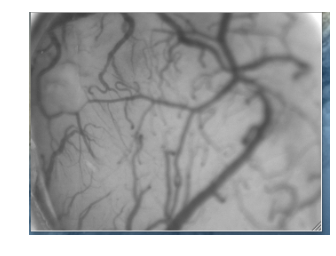

In [207]:
plt.imshow(surface, cmap='gray')
impath = os.path.join(os.path.split(imdir)[0], 'brain'+'.jpg')
plt.savefig(impath, format='jpg')

print impath
plt.axis('off')

/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/example_pixel_phase_V-Right_0_x50_y70.jpg


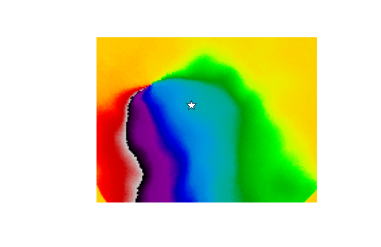

In [106]:
fig.add_subplot(1,2,2)
plt.imshow(curr_phasemap, cmap='spectral')
plt.axis('off')
plt.plot(curry, currx, 'w*', markersize=10)

imname = "example_pixel_phase_%s_x%i_y%i" % (cond, currx, curry)
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/example_pixel_mag_V-Right_0_x50_y70.jpg


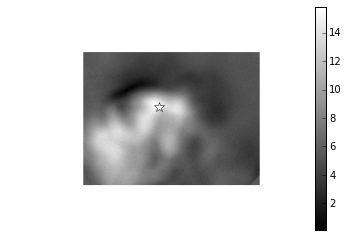

In [112]:
fig.add_subplot(1,2,2)
# curr_magmap = 2*D['mag_map'] / len(D['freqs'])*.5

Ny = len(D['freqs'])/2.
           
curr_magmap = D['mag_map'] / Ny
plt.imshow(curr_magmap, cmap='gray')
plt.axis('off')
plt.plot(curry, currx, 'w*', markersize=10)
plt.colorbar()


imname = "example_pixel_mag_%s_x%i_y%i" % (cond, currx, curry)
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

X dim:  164
Y dim:  218
96.9603592997 0.0028595412204
18.125827747
At x=120, y=200, norm-mag = 16.32, phase = 2.00
129.646706511 0.000530006808276
20.671489366
At x=120, y=175, norm-mag = 11.74, phase = 2.95
69.2272910381 0.00201692752069
14.0924584326
At x=100, y=150, norm-mag = 7.90, phase = -0.75
/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/sample_pixel_V-Right_3_x100_y150.jpg


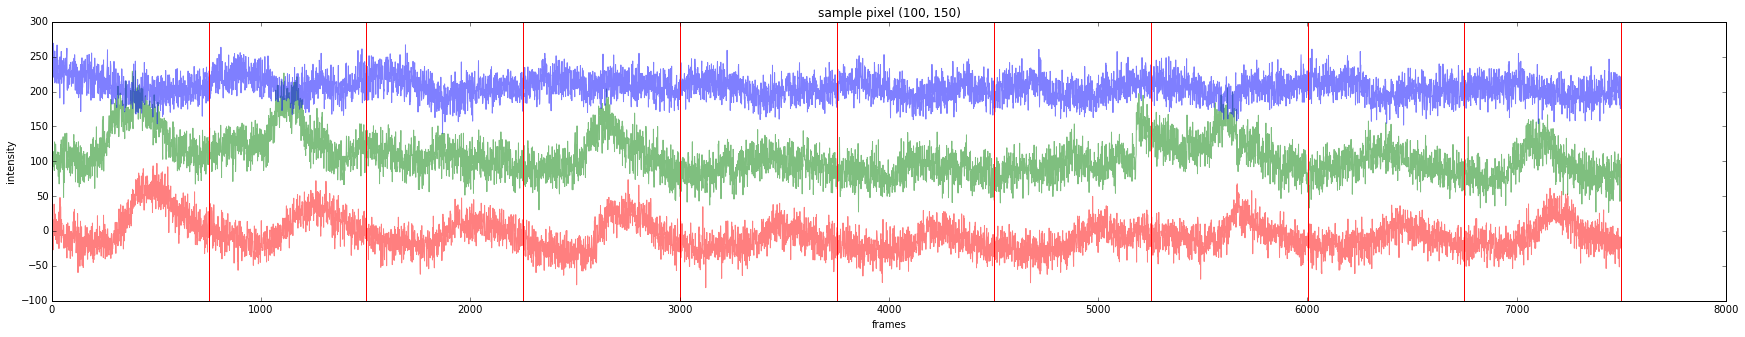

In [258]:
import numpy.fft as fft
import plotly.plotly as py


# fig = plt.figure()
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)

D = pkl.load(open(structdir, 'rb'))
# print D.keys()
phase_map = D['phase_map']

# xlocs = [140, 140]
# ylocs = [150, 200]

xlocs = [110, 110]
ylocs = [150, 200]

xlocs = [120, 120, 100]
ylocs = [200, 175, 150]

color = ['r', 'g', 'b']
# y=200 #55 #186 #157
# x=140 #146 #103

# y1=150 #200
# x1=140 #103

# x=80
# y=200
print "X dim: ", stack.shape[0]
print "Y dim: ", stack.shape[1]

# pix = stack[x,y,:]
# # pix_sub = stack[x,y,:] - np.mean(average_stack.ravel())
# pix1 = stack[x1,y1,:]

ncycles = 10
prange = ncycles*min(nframes_per_cycle)

for i in range(len(xlocs)):
    pix = stack[xlocs[i], ylocs[i]]

    t = range(len(pix))
    plt.plot(t[0:prange], pix[0:prange] + 100*i, color[i], alpha=0.5)

    for si in strt_idxs[0:ncycles+1]:
        plt.axvline(si,color='r')
    plt.xlabel('frames')
    plt.ylabel('intensity')
    plt.title('sample pixel (%i, %i)' % (xlocs[i], ylocs[i]))

    # plt.tight_layout()
    print max(abs(pix)), min(abs(pix))
    print np.mean(abs(pix))
    print "At x=%i, y=%i, norm-mag = %.2f, phase = %.2f" % (xlocs[i], ylocs[i], normed_mag[xlocs[i], ylocs[i]], phase_map[xlocs[i], ylocs[i]])


outdir = os.path.split(imdir)[0]
condition = os.path.split(imdir)[1]

imname = "sample_pixel_%s_x%i_y%i" % (cond, xlocs[i], ylocs[i])
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

(-0.5, 399.5, 249.5, -0.5)

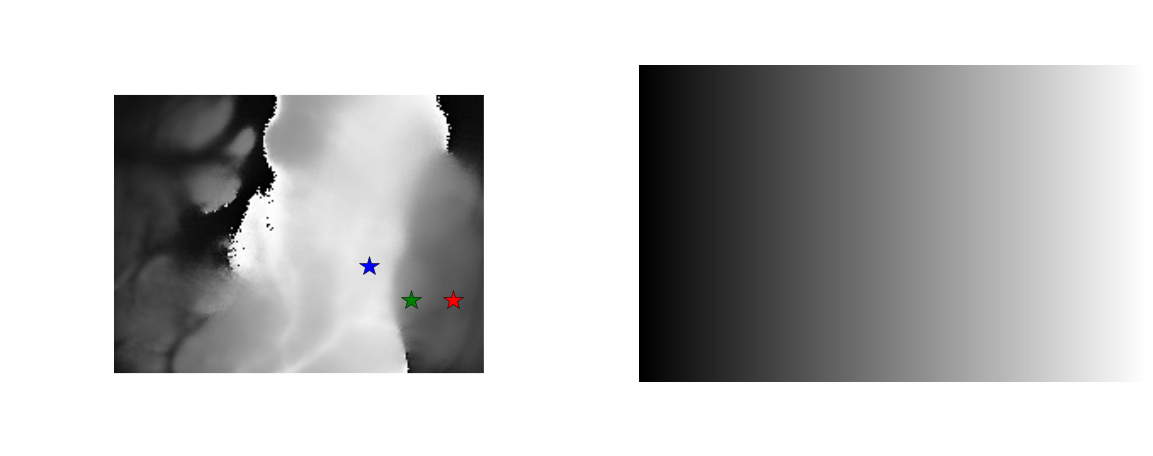

In [259]:
import math
fig = plt.figure(figsize = (20,10))

fig.add_subplot(1,2,1)
pmap = D['phase_map']
for x in range(pmap.shape[0]):
    for y in range(pmap.shape[1]):
        if pmap[x, y] < 0:
            pmap[x, y] += 2*math.pi

# D = pkl.load(open(structdir, 'rb'))
# phase = D['phase_map']

# # plt.imshow(phase, cmap='gray', vmin=0, vmax=2*math.pi)
# plt.imshow(phase, cmap='gray') # vmin=-1*math.pi, vmax=math.pi)
# for i in range(len(xlocs)):
#     plt.plot(ylocs[i], xlocs[i], color[i]+'*', markersize=20)
# plt.axis('off')
# plt.colorbar()

# fig.add_subplot(1,2,2)
plt.imshow(pmap, cmap='gray') # vmin=-1*math.pi, vmax=math.pi)

for i in range(len(xlocs)):
    plt.plot(ylocs[i], xlocs[i], color[i]+'*', markersize=20)
plt.axis('off')
# plt.colorbar()


fig.add_subplot(1,2,2)

screen_size=[400,250]
V_right_legend = np.zeros((screen_size[1], screen_size[0]))
nspaces_start = np.linspace(0, 2*math.pi, screen_size[0])
                                                      
for i in range(screen_size[1]):
    V_right_legend[i][0::] = nspaces_start
                                                      
# # FOR SPLIT SCREEN:
# # First, set half the screen width (0 to 239 = to 0 to -pi)
# nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
# for i in range(screen_size[1]):
#     V_right_legend[i][0:screen_size[0]/2] = nspaces_start
# # Then, set right side of screen (240 to end = to pi to 0)
# nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
# for i in range(screen_size[1]):
#     V_right_legend[i][screen_size[0]/2:] = nspaces_end
                                                          
plt.imshow(V_right_legend, cmap='gray')
plt.axis('off')

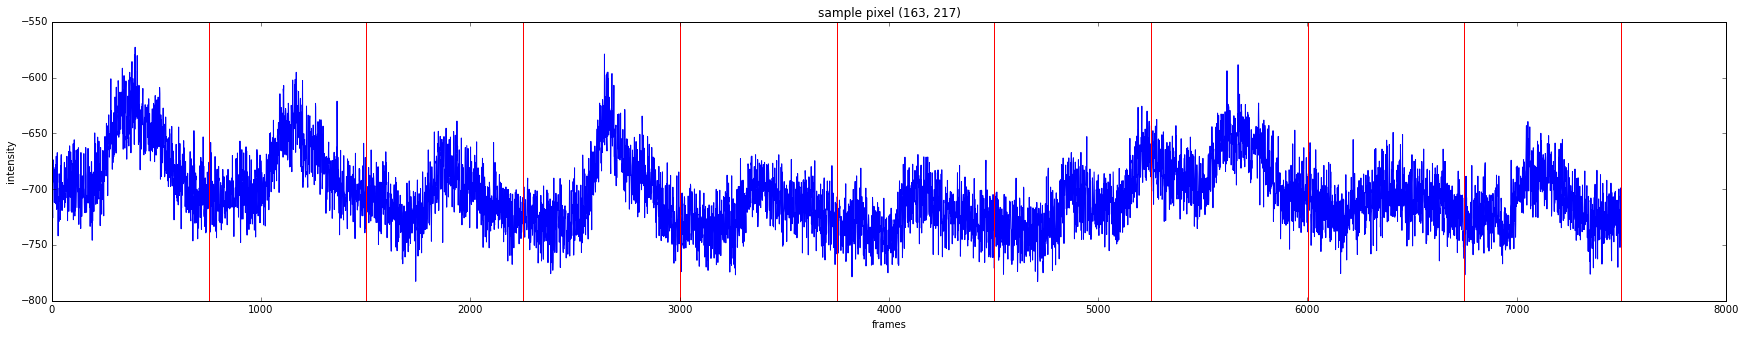

In [260]:
# fig = plt.figure()
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)

plt.plot(t[0:prange], pix_sub[0:prange])
for i in strt_idxs[0:ncycles+1]:
	plt.axvline(i,color='r')
plt.xlabel('frames')
plt.ylabel('intensity')
plt.title('sample pixel (%i, %i)' % (x, y))

In [72]:
get_average_cycle = True

if get_average_cycle:

    print "averaging cycles..."

    idxs = strt_idxs[0:20]
    min_nframes = min(nframes_per_cycle)
    blocks = []
    for i, s in enumerate(idxs):

        block = stack[:,:,s:s+min_nframes]  #[s:s+min_nframes]
        blocks.append(block)

    average_cycle = sum(blocks) / len(blocks)

averaging cycles...


Phase at x=80, y=200 (r): 2.49
Phase at x=80, y=160 (g): 5.45
Phase at x=100, y=120 (b): 4.99
Phase at x=100, y=50 (k): 1.27


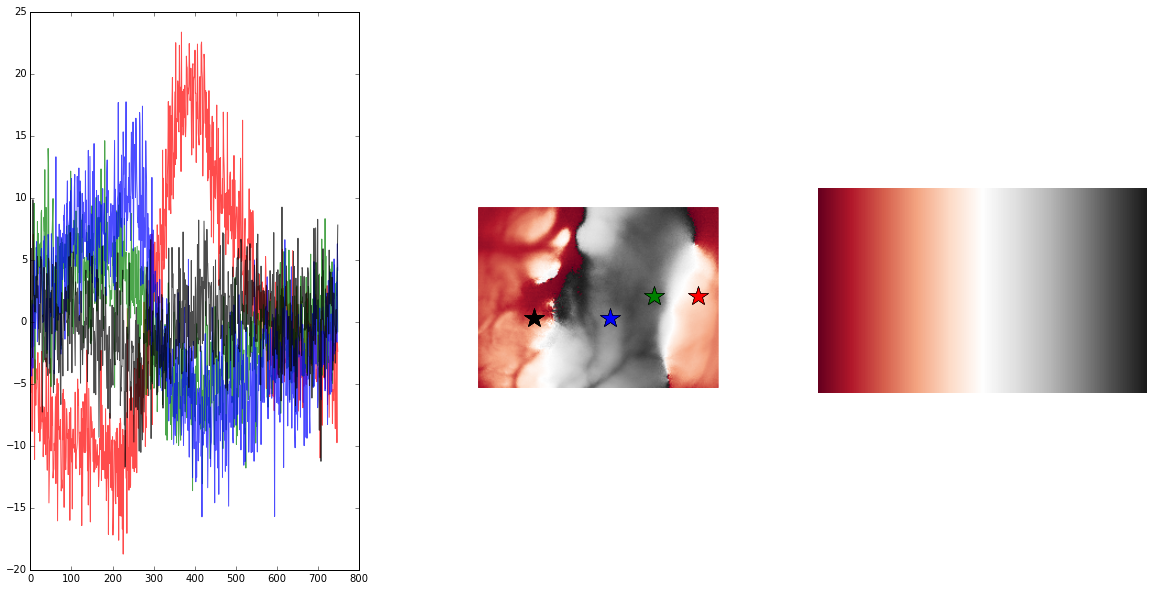

In [287]:
average_cycle.shape

D = pkl.load(open(structdir, 'rb'))
# print D.keys()
phase_map = D['phase_map']

ax_locs = [80, 80, 100, 100]
ay_locs = [200, 160, 120, 50]
colors = ['r', 'g', 'b', 'k']
fig = plt.figure(figsize=(20,10))
for i in range(len(ax_locs)):
    ax = ax_locs[i] #80
    ay = ay_locs[i] #200
    color = colors[i]

    apix = average_cycle[ax, ay,:]
    fig.add_subplot(1,3,1)
    plt.plot(apix, color+'-', alpha=0.7)
    print "Phase at x=%i, y=%i (%s): %.2f" % (ax, ay, colors[i], pmap[ax, ay])

    fig.add_subplot(1,3,2)
    plt.imshow(pmap, cmap='RdGy') # vmin=-1*math.pi, vmax=math.pi)
#     plt.colorbar()
    for i in range(len(xlocs)):
        plt.plot(ay, ax, color+'*', markersize=20)
    plt.axis('off')


    fig.add_subplot(1,3,3)
    plt.imshow(V_right_legend, cmap='RdGy')
    plt.axis('off')